# Time Series Forecasting EDA

Exploratory Data Analysis for cash flow data.

In [83]:
!pip install statsmodels


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Load Data

In [84]:
dataset_path = os.path.join('..', '..', 'Raw_Dataset', 'Datathon Dataset.xlsx - Data - Main.csv')

if os.path.exists(dataset_path):
    print(f"Loading data from {dataset_path}...")
    df_main = pd.read_csv(dataset_path)
    print(f"Data loaded successfully. Shape: {df_main.shape}")
else:
    print(f"File not found at {dataset_path}. Please check the path.")

File not found at ..\..\Raw_Dataset\Datathon Dataset.xlsx - Data - Main.csv. Please check the path.


## 2. Preprocessing

In [ ]:
# 1. Convert Pstng Date to datetime
df_main['Pstng Date'] = pd.to_datetime(df_main['Pstng Date'], errors='coerce')

# Drop rows with invalid dates if any
df_main = df_main.dropna(subset=['Pstng Date'])

# Ensure Amount is numeric
df_main['Amount in USD'] = pd.to_numeric(df_main['Amount in USD'], errors='coerce')
df_main = df_main.dropna(subset=['Amount in USD'])

# 2. Aggregate by Pstng Date, summing Amount in USD
daily_agg = df_main.groupby('Pstng Date')['Amount in USD'].sum()

# 3. Create a complete daily date range
full_idx = pd.date_range(start=daily_agg.index.min(), end=daily_agg.index.max(), freq='D')

# 4. Reindex the daily dataframe
# 5. Fill missing dates with 0
df_daily = daily_agg.reindex(full_idx, fill_value=0).to_frame(name='Amount in USD')

print(f"Daily dataframe shape: {df_daily.shape}")
df_daily.head()

Daily dataframe shape: (303, 1)


,Amount in USD
2025-01-02,-8294.80672
2025-01-03,-24063.68870
2025-01-04,-15773.58163
2025-01-05,-9757.17926
2025-01-06,-24245.89771


## 3. Visualizations

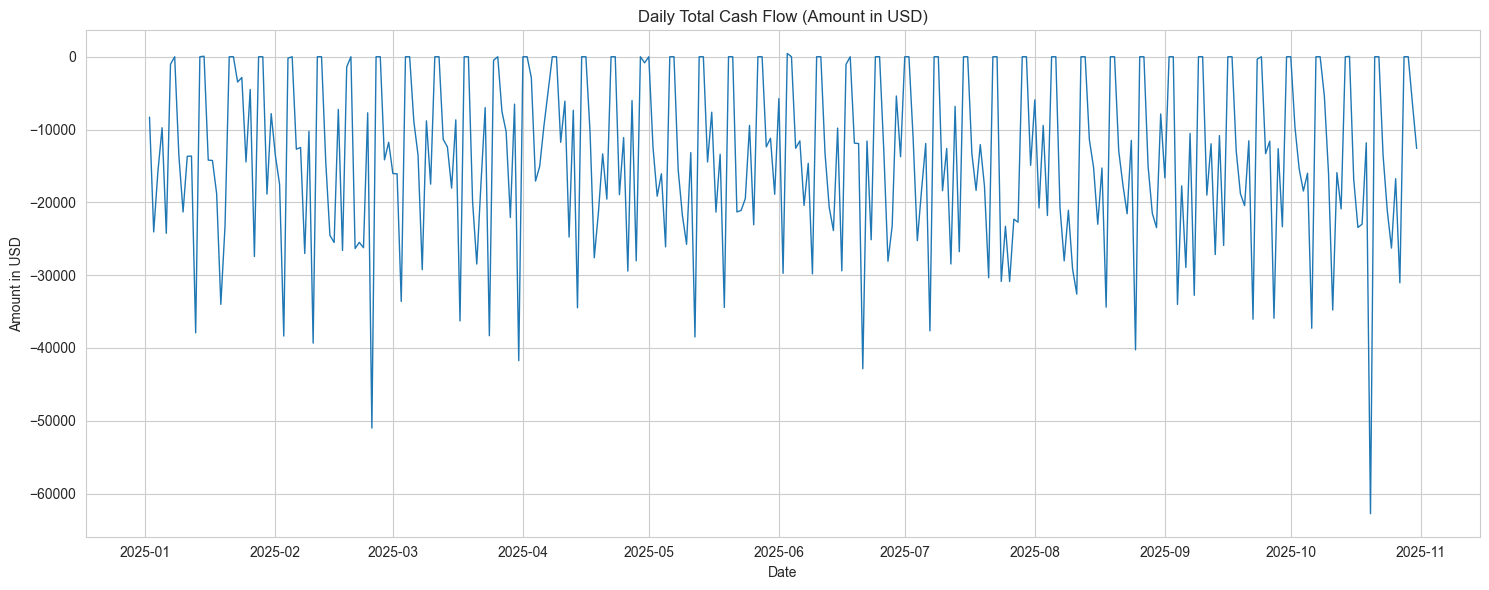

In [ ]:
# 1. Daily Time Series
plt.figure(figsize=(15, 6))
plt.plot(df_daily.index, df_daily['Amount in USD'], linewidth=1)
plt.title('Daily Total Cash Flow (Amount in USD)')
plt.xlabel('Date')
plt.ylabel('Amount in USD')
plt.grid(True)
plt.tight_layout()
plt.show()

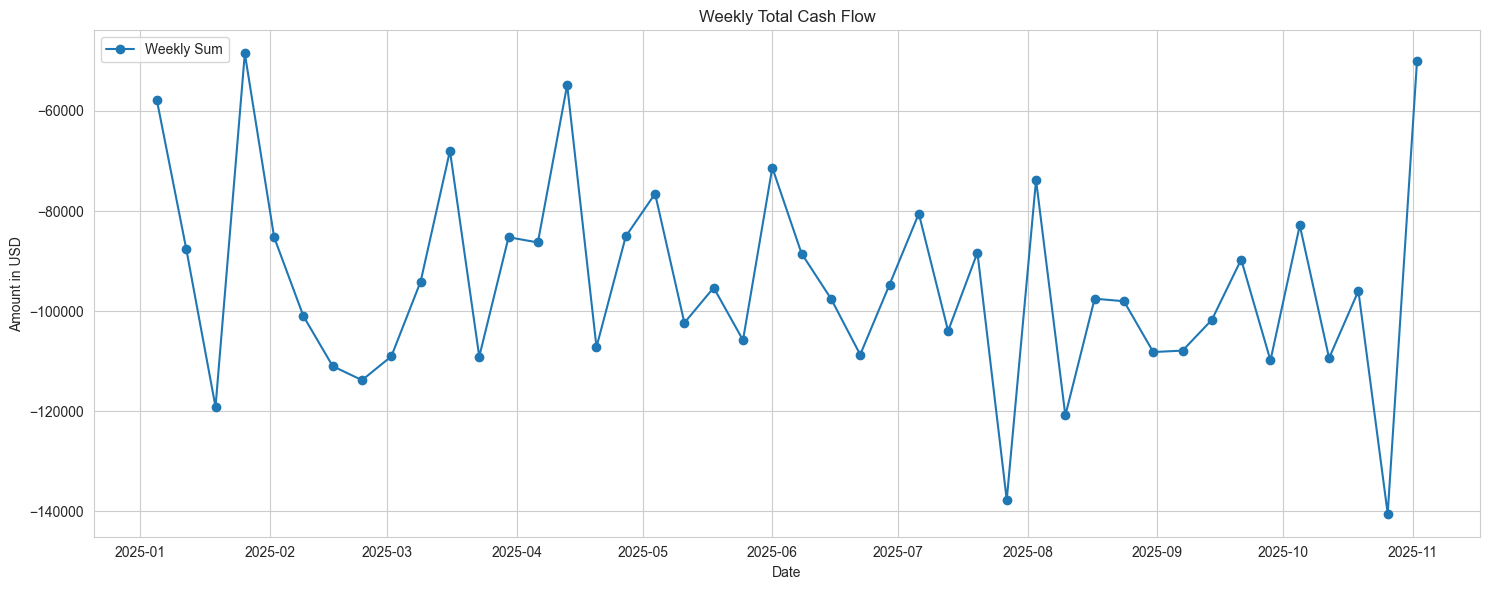

In [ ]:
# 2. Weekly Time Series
df_weekly = df_daily.resample('W').sum()

plt.figure(figsize=(15, 6))
plt.plot(df_weekly.index, df_weekly['Amount in USD'], marker='o', linestyle='-', label='Weekly Sum')
plt.title('Weekly Total Cash Flow')
plt.xlabel('Date')
plt.ylabel('Amount in USD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

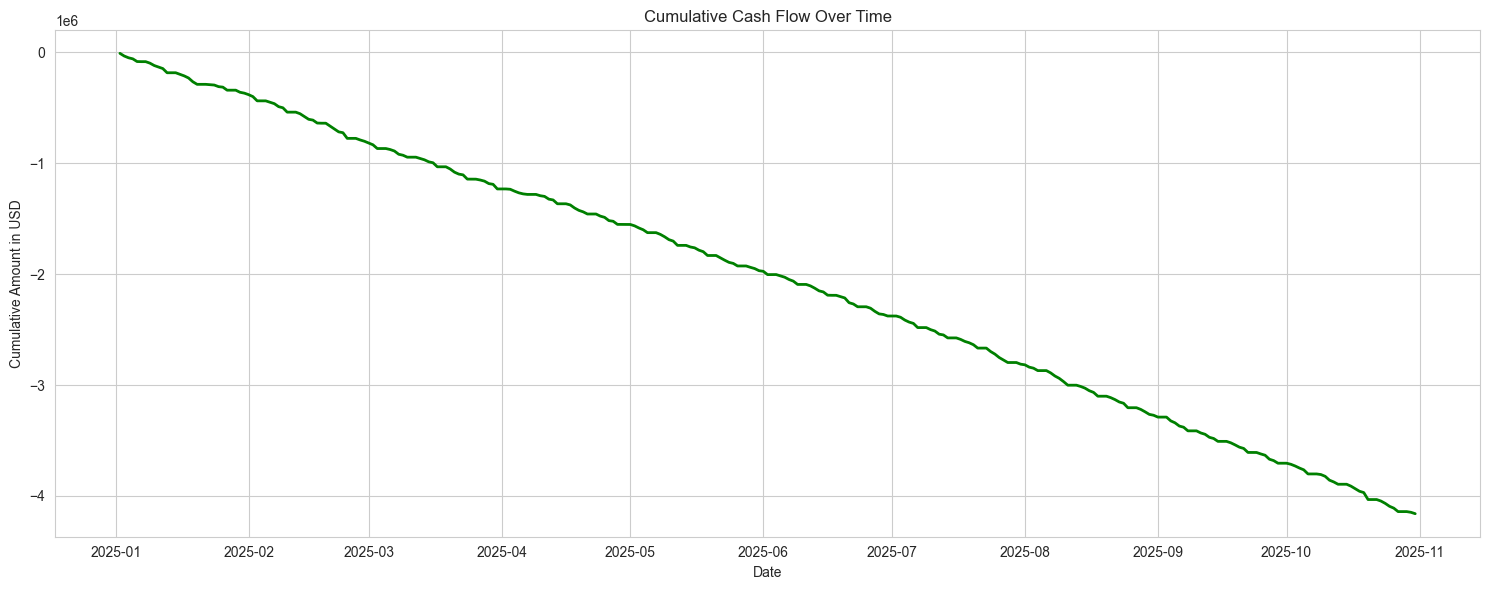

In [ ]:
# 3. Cumulative Cash Flow
df_daily['Cumulative Amount'] = df_daily['Amount in USD'].cumsum()

plt.figure(figsize=(15, 6))
plt.plot(df_daily.index, df_daily['Cumulative Amount'], color='green', linewidth=2)
plt.title('Cumulative Cash Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Amount in USD')
plt.grid(True)
plt.tight_layout()
plt.show()

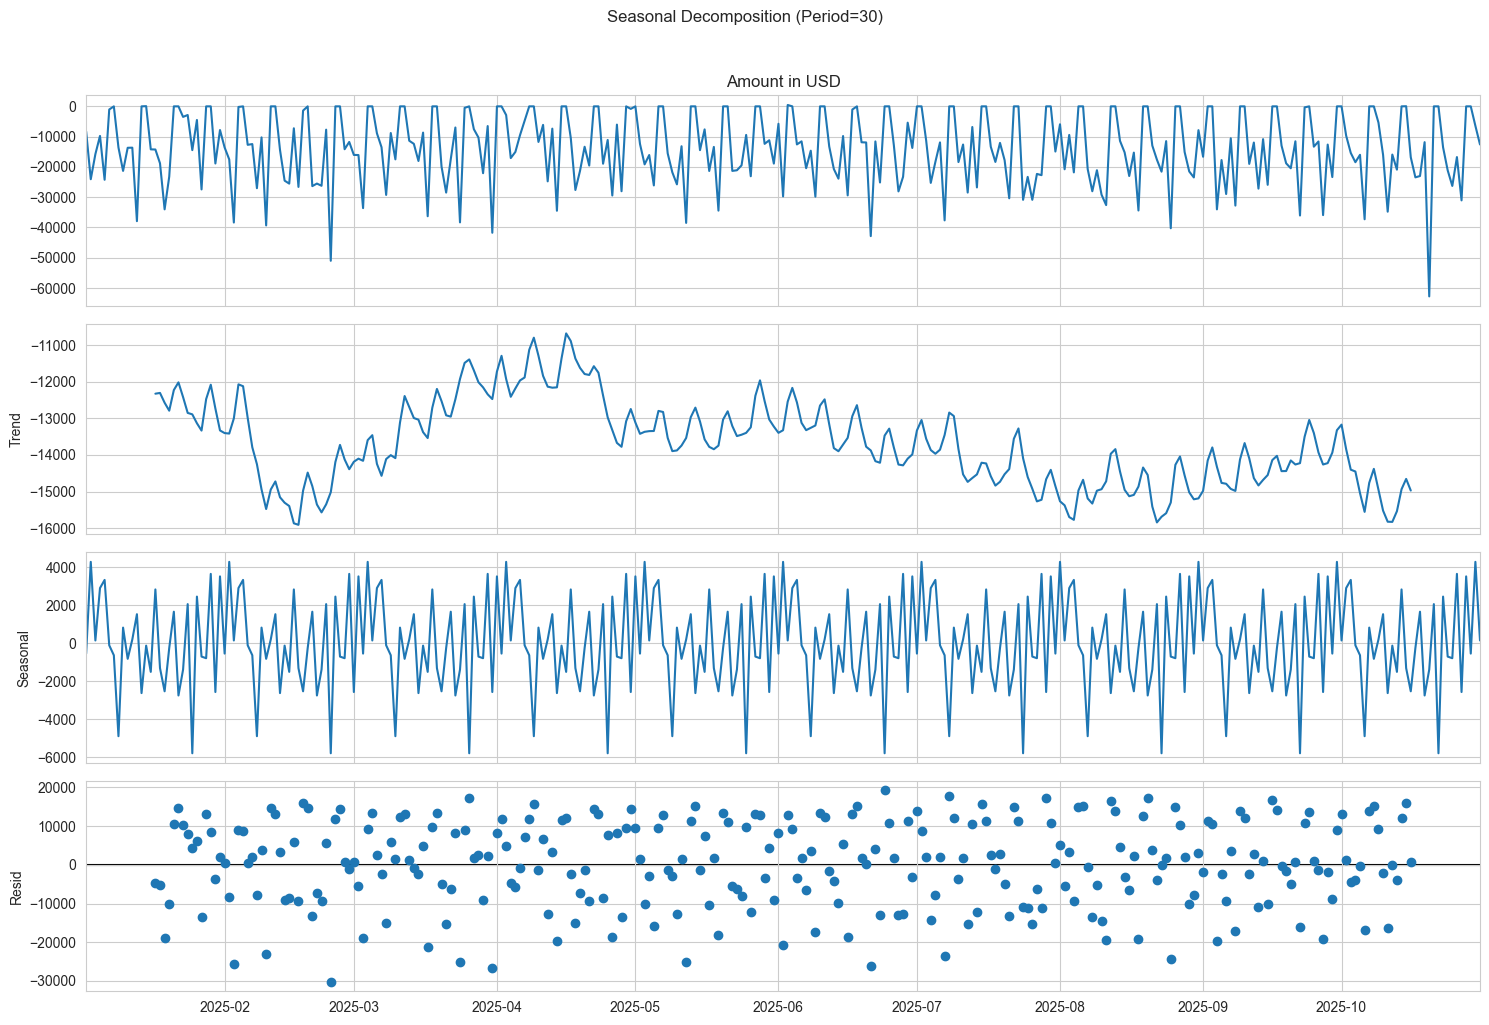

In [ ]:
# 4. Seasonal Decomposition
decomposition = seasonal_decompose(df_daily['Amount in USD'], model='additive', period=30)

fig = decomposition.plot()
fig.set_size_inches(15, 10)
fig.suptitle('Seasonal Decomposition (Period=30)', y=1.02)
plt.tight_layout()
plt.show()

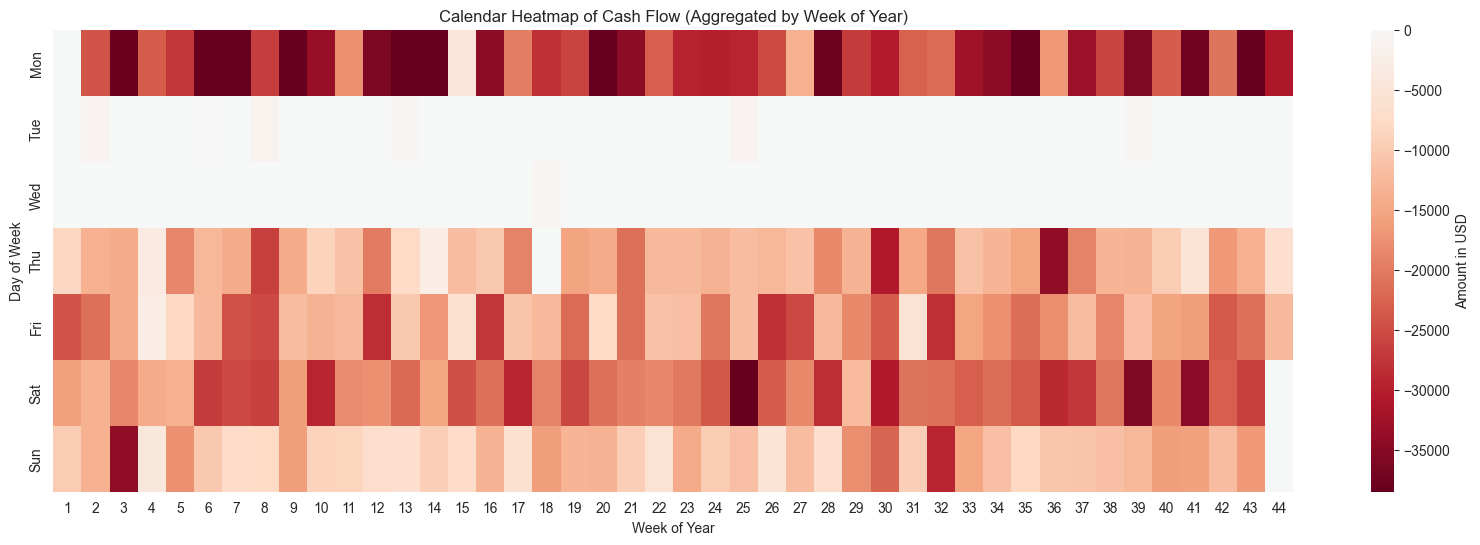

In [ ]:
# 5. Calendar Heatmap
df_heatmap = df_daily.copy()

# Extract time components
df_heatmap['Week'] = df_heatmap.index.isocalendar().week
df_heatmap['DayOfWeek'] = df_heatmap.index.dayofweek  # 0=Monday, 6=Sunday
df_heatmap['Year'] = df_heatmap.index.year

# Pivot table: Summing amounts by Week and Day of Week
# Note: If data spans multiple years, this overlays them. For strict calendar view per year, filter by year.
heatmap_data = df_heatmap.groupby(['DayOfWeek', 'Week'])['Amount in USD'].sum().unstack(fill_value=0)

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data.index = [day_names[i] for i in heatmap_data.index]

plt.figure(figsize=(20, 6))
sns.heatmap(heatmap_data, cmap='RdBu', center=0, robust=True, cbar_kws={'label': 'Amount in USD'})
plt.title('Calendar Heatmap of Cash Flow (Aggregated by Week of Year)')
plt.xlabel('Week of Year')
plt.ylabel('Day of Week')
plt.show()

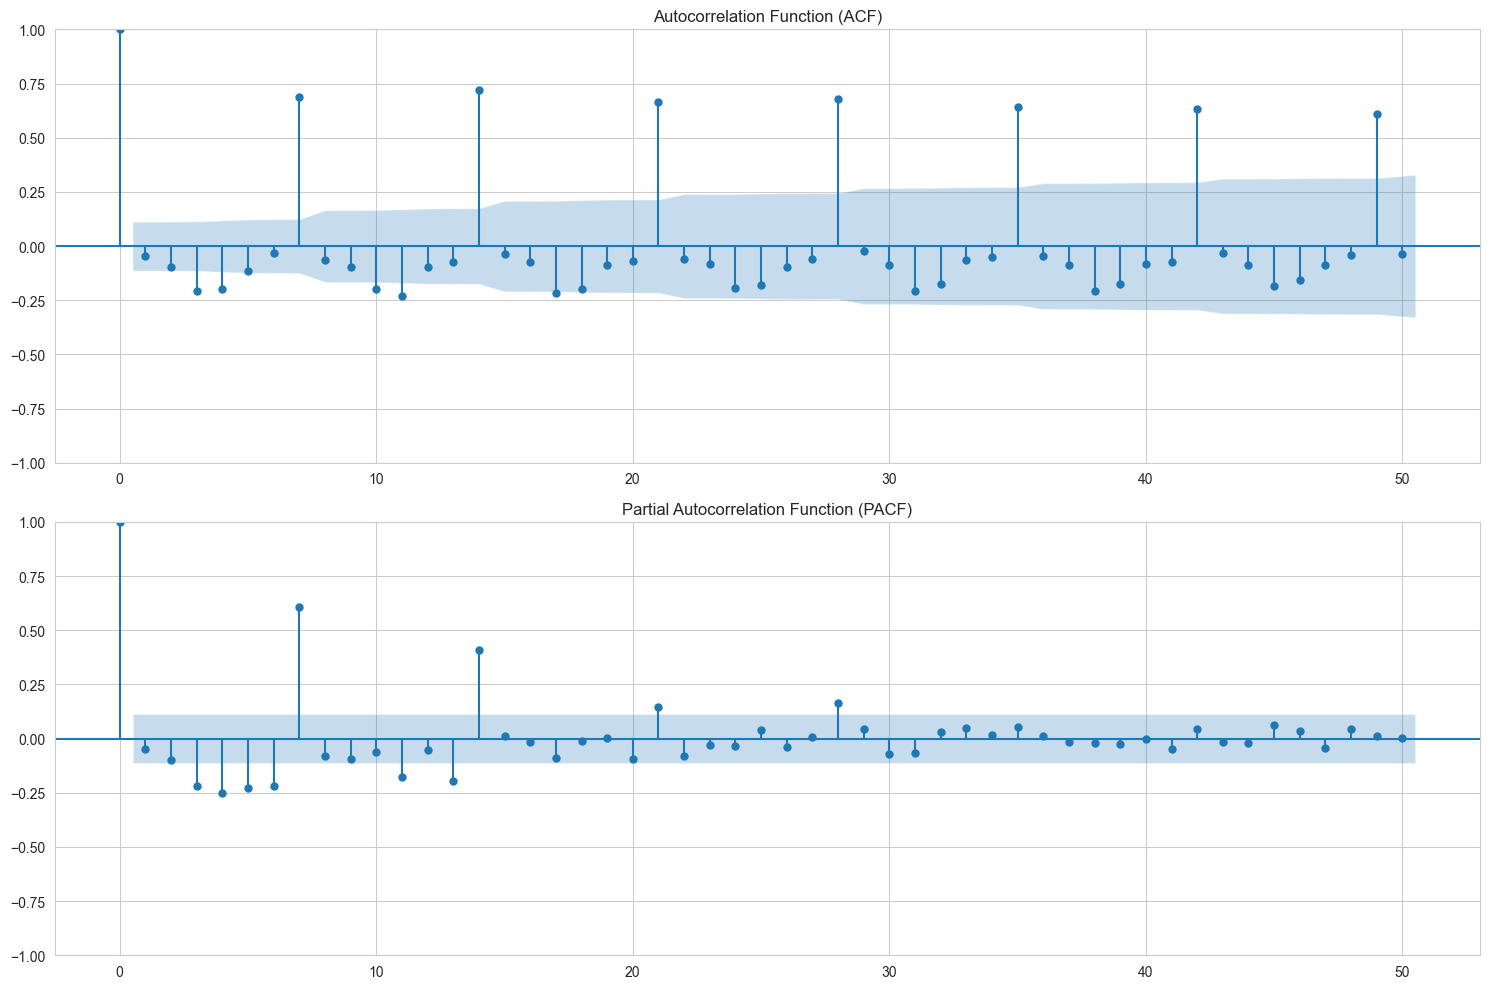

In [ ]:
# 6. Autocorrelation Analysis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(df_daily['Amount in USD'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(df_daily['Amount in USD'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

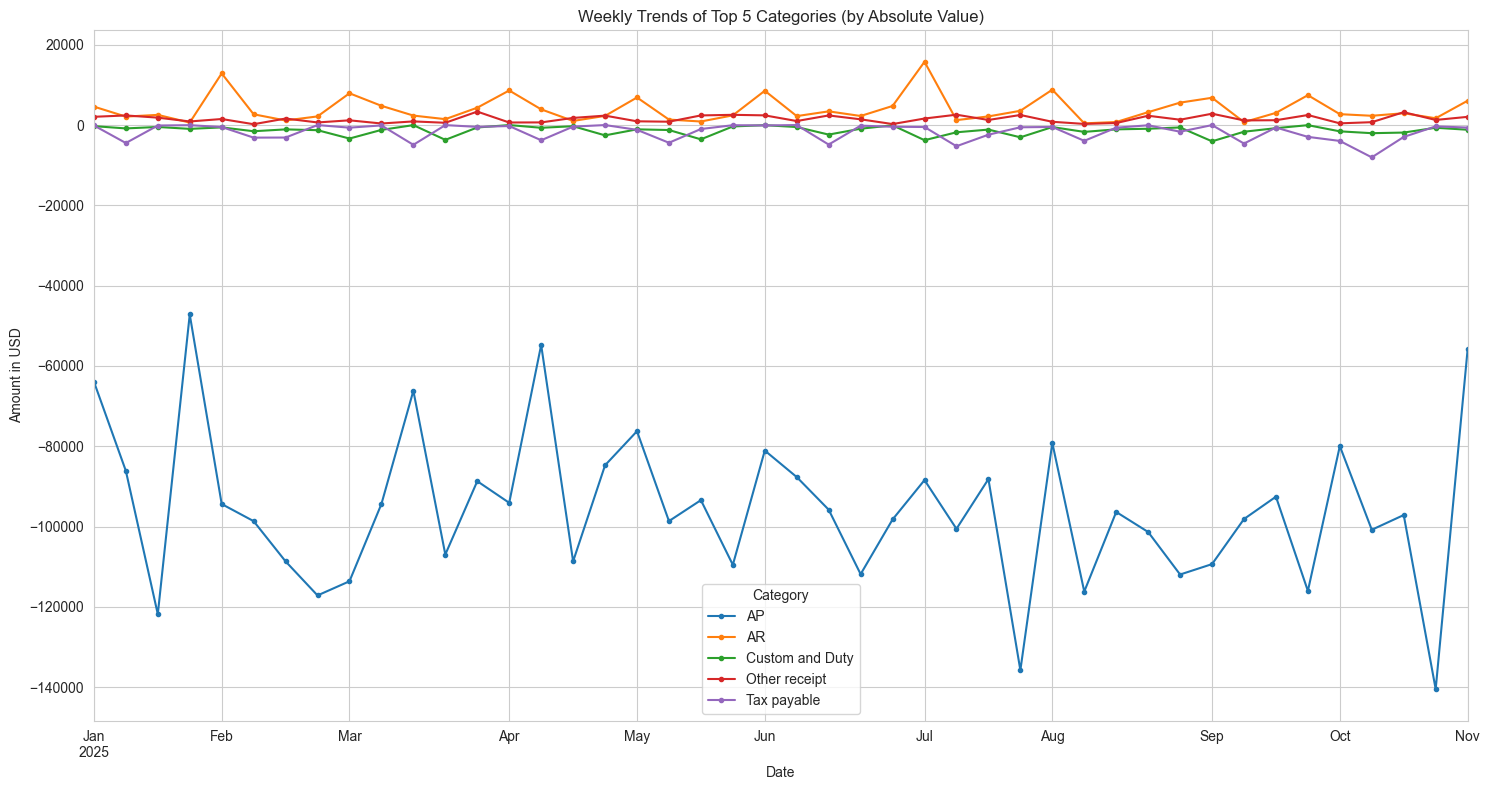

In [ ]:
# 7. Top 5 Categories
# Identify top 5 Categories by absolute total Amount in USD
top_cats_idx = df_main.groupby('Category')['Amount in USD'].apply(lambda x: x.abs().sum()).nlargest(5).index

df_cats = df_main[df_main['Category'].isin(top_cats_idx)].copy()
df_cats_weekly = df_cats.groupby([pd.Grouper(key='Pstng Date', freq='W'), 'Category'])['Amount in USD'].sum().unstack(fill_value=0)

plt.figure(figsize=(15, 8))
df_cats_weekly.plot(kind='line', marker='.', ax=plt.gca())
plt.title('Weekly Trends of Top 5 Categories (by Absolute Value)')
plt.xlabel('Date')
plt.ylabel('Amount in USD')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()
plt.show()

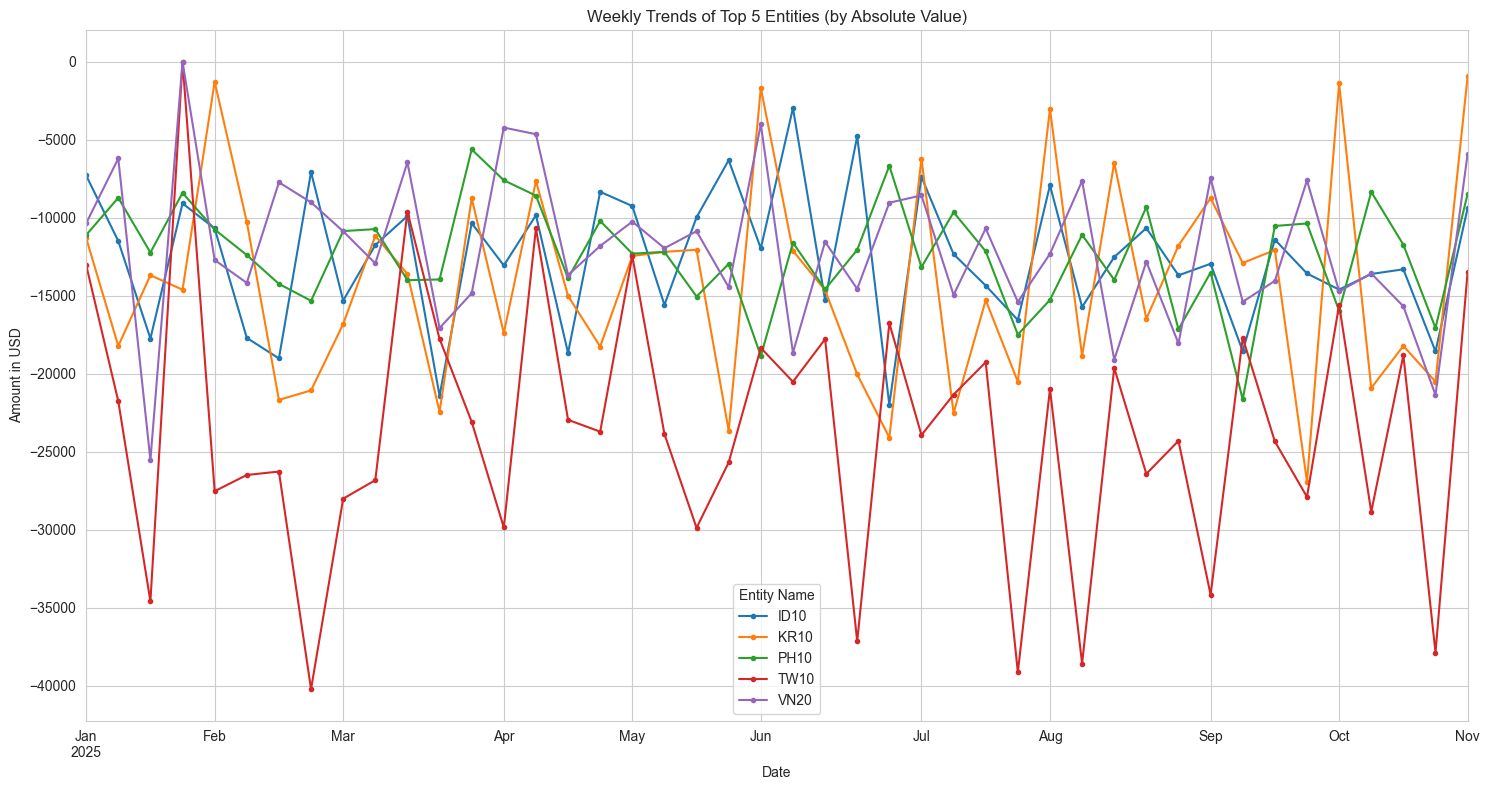

In [ ]:
# 8. Top 5 Entities (Name)
# Identify top 5 Names by absolute total Amount in USD
top_names_idx = df_main.groupby('Name')['Amount in USD'].apply(lambda x: x.abs().sum()).nlargest(5).index

df_names = df_main[df_main['Name'].isin(top_names_idx)].copy()
df_names_weekly = df_names.groupby([pd.Grouper(key='Pstng Date', freq='W'), 'Name'])['Amount in USD'].sum().unstack(fill_value=0)

plt.figure(figsize=(15, 8))
df_names_weekly.plot(kind='line', marker='.', ax=plt.gca())
plt.title('Weekly Trends of Top 5 Entities (by Absolute Value)')
plt.xlabel('Date')
plt.ylabel('Amount in USD')
plt.legend(title='Entity Name')
plt.grid(True)
plt.tight_layout()
plt.show()

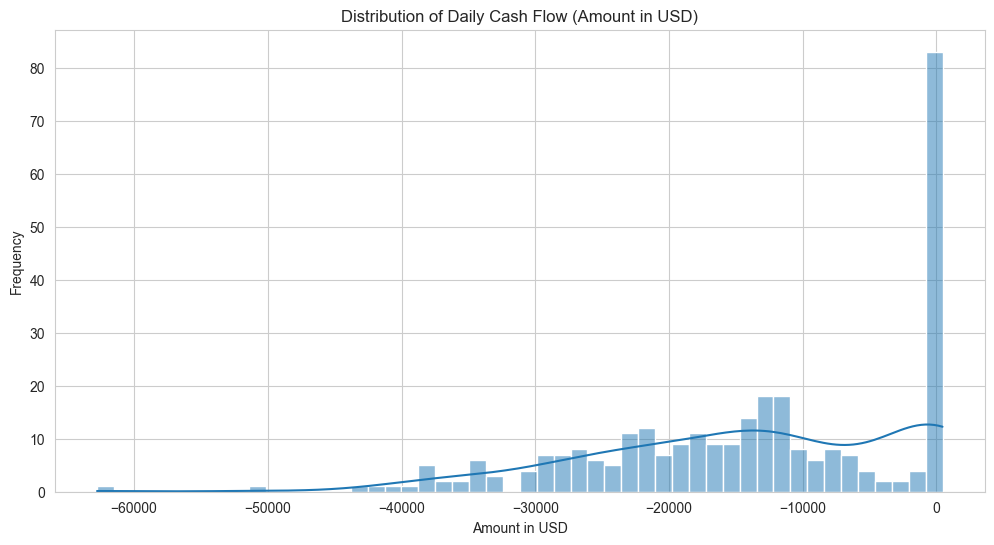

In [ ]:
# 9. Distribution Analysis
plt.figure(figsize=(12, 6))
sns.histplot(df_daily['Amount in USD'], kde=True, bins=50)
plt.title('Distribution of Daily Cash Flow (Amount in USD)')
plt.xlabel('Amount in USD')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()